<a href="https://colab.research.google.com/github/nachoacev/practice-data-science/blob/main/IntermediateML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We will accelerate our machine learning expertise by learning how to:

- Tackle data types often found in real-world datasets (**missing values, categorical variables**).
- Design **pipelines** to improve the quality of your machine learning code.
- Use advanced techniques for model validation (**cross-validation**).
- Build state-of-the-art models that are widely used to win Kaggle competitions (**XGBoost**).
- Avoid common and important data science mistakes (**leakage**).

Along the way, we'll apply our knowledge by completing a **hands-on exercise with real-world data** for each new topic. The hands-on exercises use data from the Housing Prices Competition for Kaggle Learn Users, where you'll use 79 different explanatory variables (such as the type of roof, number of bedrooms, and number of bathrooms) to predict home prices. You'll measure your progress by submitting predictions to this competition and watching your position rise on the leaderboard!

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 5)

path_train = "/content/train.csv"
path_test = "/content/test.csv"

print("Path to dataset files for training:", path_train)
print("Path to dataset files for testing:", path_test)

Path to dataset files for training: /content/train.csv
Path to dataset files for testing: /content/test.csv


We prepare the training and validation datas.

In [ ]:
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv(path_train, index_col='Id')
X_test_full = pd.read_csv(path_test, index_col='Id')

# Obtain target and predictors
y = X_full.SalePrice
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF',
            'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = X_full[features].copy()
X_test = X_test_full[features].copy()

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

FileNotFoundError: [Errno 2] No such file or directory: '/content/train.csv'

In [ ]:
X_train

,LotArea,YearBuilt,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd
Id,,,,,,,
619,11694,2007,1828,0,2,3,9
871,6600,1962,894,0,1,2,5
...,...,...,...,...,...,...,...
560,3196,2003,1557,0,2,2,7
685,16770,1998,1195,644,2,4,7


The next code cell defines five different random forest models. Run this code cell without changes.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define the models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

In [ ]:
from sklearn.metrics import mean_absolute_error

# Function for comparing different models
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))

Model 1 MAE: 24015
Model 2 MAE: 23740
Model 3 MAE: 23528
Model 4 MAE: 23996
Model 5 MAE: 23706


We see that the best model is `model_3`. We will add more trees for this one and see what we get:

In [ ]:
# Define a model
my_model = RandomForestRegressor(n_estimators=200, criterion='absolute_error', random_state=0)

# Fit the model to the training data
my_model.fit(X, y)

# Generate test predictions
preds_test = my_model.predict(X_test)

# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})

# output.to_csv('submission.csv', index=False)
output

,Id,SalePrice
0,1461,120100.04
1,1462,156445.50
...,...,...
1457,2918,131768.75
1458,2919,230416.45


# Missing Values `SimpleImputer`

We will learn three approaches to __dealing with missing values__. Then we will compare the effectiveness of these approaches on a real-world dataset.

There are many ways data can end up with missing values. For example,
- A 2 bedroom house won't include a value for the size of a third bedroom.
- A survey respondent may choose not to share his income.

Most machine learning libraries (including scikit-learn) **give an error if you try to build a model using data with missing values**. So we'll need to choose one of the strategies below.

1) A Simple Option: **Drop Columns with Missing Values (worst option)**.

The simplest option is to drop columns with missing values.


| Bed  | Bath |         | Bath |
|------|------|         |------|
| 1.0  | 1.0  |         | 1.0  |
| 2.0  | 1.0  |         | 1.0  |
| 3.0  | 2.0  |         | 2.0  |
| NaN  | 2.0  |  ---->  | 2.0  |


Unless most values in the dropped columns are missing, **the model loses access to a lot of (potentially useful!) information** with this approach. As an extreme example, consider a dataset with 10,000 rows, where one important column is missing a single entry. This approach would drop the column entirely!

2) A Better Option: **Imputation**

**Imputation fills in the missing values with some number**. For instance, we can fill in *the mean value along each column*.

| Bed  | Bath |         | Bed  | Bath |
|------|------|---------|------|------|
| 1.0  | 1.0  |         | 1.0  | 1.0  |
| 2.0  | 1.0  |         | 2.0  | 1.0  |
| 3.0  | 2.0  |         | 3.0  | 2.0  |
| NaN  | 2.0  |   ----> | 2.0  | 2.0  |

The imputed value won't be exactly right in most cases, but it usually **leads to more accurate models than you would get from dropping** the column entirely.

3) **An Extension To Imputation**

Imputation is the standard approach, and it usually works well. However, imputed values may be systematically above or below their actual values (which weren't collected in the dataset). Or rows with missing values may be unique in some other way. In that case, your model would make better predictions by considering which values were originally missing.

| Bed  | Bath |       | Bed  | Bath | Bed_was_missing |
|------|------|------|------|------|----------------|
| 1.0  | 1.0  |      | 1.0  | 1.0  | FALSE          |
| 2.0  | 1.0  |      | 2.0  | 1.0  | FALSE          |
| 3.0  | 2.0  |      | 3.0  | 2.0  | FALSE          |
| NaN  | 2.0  | ---->| 2.0  | 2.0  | TRUE           |

In this approach, __we impute the missing values__, as before. And, additionally, for each column with missing entries in the original dataset, __we add a new column that shows the location of the imputed entries__.

__In some cases, this will meaningfully improve results. In other cases, it doesn't help at all__.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/melbourne-housing-snapshot") + '/melb_data.csv'

print("Path to dataset files:", path)

100%|██████████| 451k/451k [00:00<00:00, 70.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/dansbecker/melbourne-housing-snapshot/versions/5/melb_data.csv


In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 5)
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv(path)

# Select target
y = data.Price

# To keep things simple, we'll use only numerical predictors
melb_predictors = data.drop(['Price'], axis=1)
X = melb_predictors.select_dtypes(exclude=['object'])

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

**Score from Approach 1 (Drop Columns with Missing Values)**

Since we are working with both training and validation sets, we are careful to drop the same columns in both DataFrames.

In [ ]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE from approach 1 (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE from approach 1 (Drop columns with missing values):
183550.22137772635


**Score from Approach 2 (Imputation)**

Next, we use `SimpleImputer` **to replace missing values with the mean value along each column**.

This is a function with two important methods:
- `.fit_transform()`: it create and fit the imputate transformation from the data given.
- `.transform()`: it transform according with the fitted imputation.

Although it's simple, filling in the mean value generally performs quite well (but this varies by dataset). While statisticians have experimented with more complex ways to determine imputed values (such as **regression imputation**, for instance), the **complex strategies typically give no additional benefit once you plug the results into sophisticated machine learning models**.

In [ ]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("MAE from Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE from Approach 2 (Imputation):
178166.46269899711


**Score from Approach 3 (An Extension to Imputation)**

Next, we impute the missing values, while also keeping track of which values were imputed.

In [ ]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("MAE from Approach 3 (An Extension to Imputation):")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

MAE from Approach 3 (An Extension to Imputation):
178927.503183954


We see that **Approach 2** has lower MAE than **Approach 1** and **Approach 3**, so Approach 2 performed better on this dataset.

**So, why did imputation perform better than dropping the columns?**

The training data has 10864 rows and 12 columns, where three columns contain missing data. For each column, less than half of the entries are missing. Thus, dropping the columns removes a lot of useful information, and so it makes sense that imputation would perform better.

In [ ]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(10864, 12)
Car               49
BuildingArea    5156
YearBuilt       4307
dtype: int64


__Conclusion__

As is common, imputing missing values (in **Approach 2** and **Approach 3**) yielded better results, relative to when we simply dropped columns with missing values (in **Approach 1**).

In [ ]:
missing_val_count_by_column.sum()

9512

# Categorical Variables (Ordinal and One-Hot Encoding)

We will learn what a categorical variable is, along with three approaches for handling this type of data in machine learning models.

A **categorical variable** takes only a limited number of values.

- Consider a survey that asks how often you eat breakfast and provides four options: "Never", "Rarely", "Most days", or "Every day". In this case, the data is categorical, because responses fall into a fixed set of categories.

**You will get an error if you try to plug these variables into most machine learning models in Python without preprocessing them first**. We'll compare three approaches that we can use to prepare our categorical data.

In [ ]:
# Load the data
data = pd.read_csv(path)

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8,
                                                                test_size=0.2, random_state=0)

In [ ]:
# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()]
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# Select categorical columns with relatively low cardinality (convenient, but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns
                        if X_train_full[cname].nunique() < 10
                        and X_train_full[cname].dtype == 'object']

numerical_cols = [cname for cname in X_train_full.columns
                  if X_train_full[cname].dtype in ['float64', 'int64']]

# Keep selected columns
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [ ]:
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,555.0,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,265.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,673.0,-37.76230,144.8272,4217.0


In [ ]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Type', 'Method', 'Regionname']


In [ ]:
X_train

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.98670,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.90050,6380.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10799,h,S,Northern Metropolitan,3,12.0,3073.0,3.0,1.0,606.0,-37.72057,145.02615,21650.0
2732,h,SP,Western Metropolitan,4,6.4,3011.0,4.0,2.0,319.0,-37.79430,144.88750,7570.0


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

**1) Drop Categorical Variables**

The easiest approach to dealing with categorical variables is to simply remove them from the dataset. This approach will only work well if the columns did not contain useful information.

We drop the `object` columns with the `.select_dtypes()` method.

In [ ]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
175703.48185157913


**2) Ordinal Encoding**

Ordinal encoding assigns each unique value to a different integer.

| Breakfast   |   ----->     | Breakfast |
|------------|-------|----------|
| Every day  |       | 3        |
| Never      |       | 0        |
| Rarely     |       | 1        |
| Most days  |       | 2        |
| Never      |       | 0        |

This approach **assumes an ordering of the categories**: "Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3).

This assumption makes sense in this example, because there is an indisputable ranking to the categories. **Not all categorical variables have a clear ordering in the values**, but **we refer to those that do as ordinal variables**. For tree-based models (like decision trees and random forests), you can expect ordinal encoding to work well with ordinal variables.


Scikit-learn has a `OrdinalEncoder` class that can be used to get ordinal encodings. We loop over the categorical variables and apply the ordinal encoder separately to each column.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Make a copy to avoid changing original data
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data

ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print("MAE from Approach 2 (Ordinal Encoding):")
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):
165936.40548390493


**3) One-Hot Encoding**

One-hot encoding creates new columns **indicating the presence (or absence) of each possible value in the original data**. To understand this, we'll work through an example.

| Color  | ----->| Red | Yellow | Green |
|--------|-------|-----|--------|-------|
| Red    |       |  1  |   0    |   0   |
| Red    |       |  1  |   0    |   0   |
| Yellow |       |  0  |   1    |   0   |
| Green  |       |  0  |   0    |   1   |
| Yellow |       |  0  |   1    |   0   |

In the original dataset, "Color" is a categorical variable with three categories: "Red", "Yellow", and "Green". The corresponding one-hot encoding contains one column for each possible value, and one row for each row in the original dataset. Wherever the original value was "Red", we put a 1 in the "Red" column; if the original value was "Yellow", we put a 1 in the "Yellow" column, and so on.

In contrast to ordinal encoding, **one-hot encoding does not assume an ordering of the categories**. Thus, you can expect this approach to work particularly well if there is no clear ordering in the categorical data (e.g., "Red" is neither more nor less than "Yellow"). **We refer to categorical variables without an intrinsic ranking as nominal variables**.

One-hot encoding **generally does not perform well if the categorical variable takes on a large number of values** (i.e., you generally won't use it for variables taking more than 15 different values).


We use the `OneHotEncoder` class from scikit-learn to get one-hot encodings. There are a number of parameters that can be used to customize its behavior.

- We set `handle_unknown='ignore'` to avoid errors when the validation data contains classes that aren't represented in the training data.
- We set `sparse=False` ensures that the encoded columns are returned as a numpy array (instead of a sparse matrix).

To use the encoder, *we supply only the categorical columns that we want to be one-hot encoded*. For instance, to encode the training data, we supply `X_train[object_cols]`.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encode removed index; we must put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical columns
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# Ensure all columns have string type
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)

print("MAE from Approach 3 (One-Hot Encoding):")
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):
166089.4893009678


**Which approach is better?**

In this case, dropping the categorical columns (Approach 1) performed worst, since it had the highest MAE score. As for the other two approaches, since the returned MAE scores are so close in value, there doesn't appear to be any meaningful benefit to one over the other.

**In general, one-hot encoding (Approach 3) will typically perform best**, and dropping the categorical columns (Approach 1) typically performs worst, but it varies on a case-by-case basis.

**Conclusion**

The world is filled with categorical data. We will be a much more effective data scientist if you know how to use this common data type!

## Example (Problem of cardinality and train-valid data set)

We will work again with the Housing price competition data. **This data have some usual problems in Data Cleaning and Exploratory Data Analysis (EDA)**:

- Some categorical columns in the `X_valid` **contain values that don't appear in the columns of the `X_train`**. This is a problem if we want to apply an encoder fitted via `X_train`.
- **Categorical variables with high cardinality can greatly expand the size of the dataset when we use One-Hot Encoders**. This is a problem, and we should prefer to drop them or to use Ordinal Encoding.

In [1]:
path_train = "/content/train.csv"
path_test = "/content/test.csv"

print("Path to dataset files for training:", path_train)
print("Path to dataset files for testing:", path_test)

Path to dataset files for training: /content/train.csv
Path to dataset files for testing: /content/test.csv


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X = pd.read_csv(path_train, index_col='Id')
X_test = pd.read_csv(path_test, index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll drop columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()]
X.drop(cols_with_missing, axis=1, inplace=True)
X_test.drop(cols_with_missing, axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

**1. Missing values in categorical `X_valid` wrt `X_train`**

In [5]:
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if set(X_valid[col]).issubset(set(X_train[col]))]

# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols) - set(good_label_cols))

print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['RoofMatl', 'Functional', 'Condition2']


Only now we can apply `OrdinalEncode`.

In [9]:
from sklearn.preprocessing import OrdinalEncoder

# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply ordinal encoder
ordinal_encoder = OrdinalEncoder() # Your code here
label_X_train[good_label_cols] = ordinal_encoder.fit_transform(X_train[good_label_cols])
label_X_valid[good_label_cols] = ordinal_encoder.transform(X_valid[good_label_cols])

In [10]:
print("MAE from Approach 2 (Ordinal Encoding):")
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):
17098.01649543379


**2. Cardinality of categorical variables**

In [24]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Street', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('PavedDrive', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('ExterQual', 4),
 ('KitchenQual', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Condition2', 6),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('Heating', 6),
 ('Functional', 6),
 ('SaleCondition', 6),
 ('RoofMatl', 7),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

In [25]:
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

high_cardinality_cols = list(set(object_cols) - set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Exterior2nd', 'Exterior1st', 'Neighborhood']


# Pipelines

**Pipelines** are a simple way to keep your data preprocessing and modeling code organized. Specifically, a pipeline **bundles preprocessing and modeling steps** so you can use the whole bundle as if it were a single step.

Many data scientists hack together models without pipelines, but pipelines have some important benefits. Those include:

- **Cleaner Code:** Accounting for data at each step of preprocessing can get messy. With a pipeline, you won't need to manually keep track of your training and validation data at each step.
- **Fewer Bugs:** There are fewer opportunities to misapply a step or forget a preprocessing step.
- **Easier to Productionize:** It can be surprisingly hard to transition a model from a prototype to something deployable at scale. We won't go into the many related concerns here, but pipelines can help.
- **More Options for Model Validation:** You will see an example in the next tutorial, which covers cross-validation.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('/content/train.csv', index_col='Id')
X_test_full = pd.read_csv('/content/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y,
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

`Pipeline`: A sequence of data transformers with an optional final predictor. Pipeline allows you to sequentially apply a list of transformers to preprocess the data and, if desired, conclude the sequence with a final predictor for predictive modeling.

Intermediate steps of the pipeline must be transformers, that is, they
must implement `fit` and `transform` methods.
The final estimator only needs to implement fit.

**We construct the full pipeline in three steps.**

**Step 1:** Define Preprocessing Steps
Similar to how a pipeline bundles together preprocessing and modeling steps, we use the ColumnTransformer class to bundle together different preprocessing steps. The code below:

- imputes missing values in **numerical** data, and
- imputes missing values and applies a one-hot encoding to **categorical** data.

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Processing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Processing for categorical data
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('one-got', OneHotEncoder(handle_unknown='ignore'))
                                          ])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols),
                                               ('cat', categorical_transformer, categorical_cols)
                                               ])


MAE 17540.473424657535


**Step 2:** Define the Model.

Next, we define a random forest model with the familiar RandomForestRegressor class.

In [5]:
# Define the model
model = RandomForestRegressor(n_estimators=100, random_state=0)


**Step 3:** Create and Evaluate the Pipeline.

Finally, we use the `Pipeline` class to define a pipeline that bundles the preprocessing and modeling steps. There are a few important things to notice:

- With the pipeline, **we preprocess the training data and fit the model in a single line of code**. *(In contrast, without a pipeline, we have to do imputation, one-hot encoding, and model training in separate steps. This becomes especially messy if we have to deal with both numerical and categorical variables!)*
- With the pipeline, we supply the unprocessed features in `X_valid` to the `predict()` command, and **the pipeline automatically preprocesses the features before generating predictions**. *(However, without a pipeline, we have to remember to preprocess the validation data before making predictions.)*

In [6]:
# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('prepocessor', preprocessor),
                      ('model', model)
                      ])

# Preprocessing of training data, fit model
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE', mean_absolute_error(y_valid, preds))


NameError: name 'preprocessor' is not defined

# Cross-Validation

We will learn how to use cross-validation for better measures of model performance.

ML is an iterative process. You will face choices about what predictive variables to use, what types of models to use, what arguments to supply to those models, etc.

There are some drawbacks. To see this, imagine you have a dataset with 5000 rows. You will typically keep about 20% of the data as a validation dataset, or 1000 rows. But this leaves some random chance in determining model scores. That is, a model might do well on one set of 1000 rows, even if it would be inaccurate on a different 1000 rows.

At an extreme, you could imagine having only 1 row of data in the validation set. If you compare alternative models, which one makes the best predictions on a single data point will be mostly a matter of luck!

In general, **the larger the validation set, the less randomness (aka "noise") there is in our measure of model quality**, and the more reliable it will be. **Unfortunately, we can only get a large validation set by removing rows from our training data, and smaller training datasets mean worse models!**

**What is cross-validation?**

In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.

For example, we could begin by dividing the data into 5 pieces, each 20% of the full dataset. In this case, we say that we have broken the data into 5 "folds".

| Experiment   | 1st fold  | 2nd fold  | 3rd fold  | 4th fold  | 5th fold  |
|-------------|----------|----------|----------|----------|----------|
| **Exp 1**   | *Validation* | Training  | Training  | Training  | Training  |
| **Exp 2**   | Training  | *Validation* | Training  | Training  | Training  |
| **Exp 3**   | Training  | Training  | *Validation* | Training  | Training  |
| **Exp 4**   | Training  | Training  | Training  | *Validation* | Training  |
| **Exp 5**   | Training  | Training  | Training  | Training  | *Validation* |

Then, we run one experiment for each fold:

- In Experiment 1, we use the first fold as a validation (or holdout) set and everything else as training data. This gives us a measure of model quality based on a 20% holdout set.
- In Experiment 2, we hold out data from the second fold (and use everything except the second fold for training the model). The holdout set is then used to get a second estimate of model quality.
- We repeat this process, using every fold once as the holdout set. Putting this together, 100% of the data is used as holdout at some point, and we end up with a measure of model quality that is based on all of the rows in the dataset (even if we don't use all rows simultaneously).

**So, given these tradeoffs, when should you use each approach?**

For small datasets, where extra computational burden isn't a big deal, you should run cross-validation. For larger datasets, a single validation set is sufficient. Your code will run faster, and you may have enough data that there's little need to re-use some of it for holdout.

*There's no simple threshold for what constitutes a large vs. small dataset*. But if your model takes a couple minutes or less to run, it's probably worth switching to cross-validation.

Alternatively, you can run cross-validation and see if the scores for each experiment seem close. If each experiment yields the same results, a single validation set is probably sufficient.


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
train_data = pd.read_csv('/content/train.csv', index_col='Id')
test_data = pd.read_csv('/content/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = train_data.SalePrice
train_data.drop(['SalePrice'], axis=1, inplace=True)

# Select numeric columns only
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
X = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                               ('model', RandomForestRegressor(n_estimators=50, random_state=0))
                               ])

In [9]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')

print("Average MAE score:", scores.mean())

Average MAE score: 18276.410356164386


**Hyperparameter Optimization**

We will optimize the parameter `n_estimators` easily via CrossValidation.

We practice how to manage `Dictionaries` in python.

In [11]:
def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.

    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                               ('model', RandomForestRegressor(n_estimators=n_estimators, random_state=0))
                               ])
    scores = -1 * cross_val_score(pipeline, X, y, cv=3, scoring='neg_mean_absolute_error')

    return scores.mean()


In [12]:
# Store results in a dictionary
# # first way
# results = {}

# for i in range(1, 9):
#   results[50*i] = get_score(50*i)

# # second way
# results = dict([(50*i, get_score(50*i)) for i in range(1, 9)])

# third way
results = {50*i: get_score(50*i) for i in range(1, 9)}

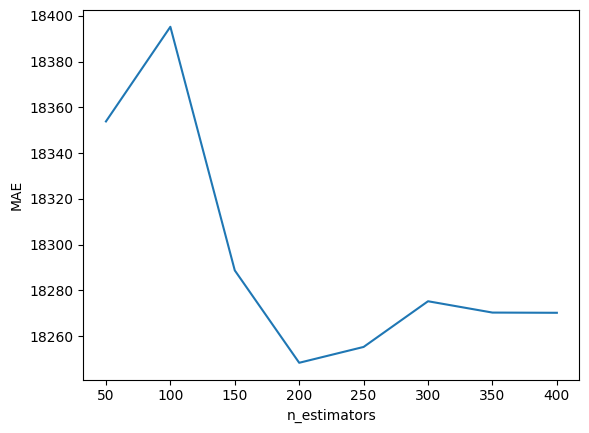

In [15]:
import matplotlib.pyplot as plt
# %matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.show()